In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha

delphesDir = os.path.abspath("../MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.24/06


# Set Delphes output files

In [2]:
inputFiles = {'no Bias' : '../DMSimp_monojet_LO_1j/Events/run_01/noBias_delphes_events.root'}

# Load Model Parameters

In [3]:
parameters = {}
for label,file in inputFiles.items():
    banner = list(glob.glob(os.path.dirname(file)+'/*banner.txt'))
    if len(banner) != 1:
        print('%i banner files found for %s!' %(len(banner),label))
        continue
    else:
        banner = banner[0]
    xtree = ET.parse(banner)
    xroot = xtree.getroot()
    xsecPB = eval(xroot.find('init').text.split()[-2])
    slha = xroot.find('header').find('slha').text
    pars = pyslha.readSLHA(slha)
    mMed = pars.blocks['MASS'][55]
    mDM = pars.blocks['MASS'][52]
    gVq = pars.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
    gAq = pars.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
    gVx = pars.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
    gAx = pars.blocks['DMINPUTS'][3] # Mediator-DM axial coupling
    parameters[label] = {'xsec(pb)' : xsecPB, 'mMed' : mMed, 'mDM' : mDM, 
                         'gVq' : gVq, 'gAq' : gAq, 'gVx' : gVx, 'gAx' : gAx}
    print(label,': mMed = %1.2f GeV, mDM = %1.2f GeV, cross-section = %1.3e pb' %(mMed,mDM,xsecPB))

2 banner files found for no Bias!


# Load events, get parton level and detector level MET

In [4]:
pTj1 = {label : np.array([]) for label in inputFiles}
weights = {label : np.array([]) for label in inputFiles}
met = {label : np.array([]) for label in inputFiles}
genMet = {label : np.array([]) for label in inputFiles}
dmPT = {label : np.array([]) for label in inputFiles}
totalweight = {label : 0.0 for label in inputFiles}

    
for label,inputFile in inputFiles.items():

    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
#     parameters[label]['Events'] = nevts
    
    for ievt in range(nevts):    
        tree.GetEntry(ievt)        

        particles = tree.Particle
       
        # Get DM particles (gen level)
        dmList = []
        for ip in range(particles.GetEntries()):
            p = particles.At(ip)
            if abs(p.PID) != 52:
                continue
            if p.Status != 1:
                continue
            dmList.append(p)
            
        if len(dmList) !=2:
            # Skip events with Mediator -> j j
            continue

        weight = tree.Event.At(0).Weight
        weight = weight/nevts
        totalweight[label] += weight

        missingET = tree.MissingET.At(0)
        genMissingET = tree.GenMissingET.At(0)  # USE REAL MISSING ET!
        
        if missingET.MET < 250.:
            continue
        
        # Store relevant data        
        dmPT[label] = np.append(dmPT[label],np.sqrt((dmList[0].Px + dmList[1].Px)**2 
                                                    + (dmList[0].Py + dmList[1].Py)**2))
        
        weights[label] = np.append(weights[label],weight)
        met[label] = np.append(met[label],missingET.MET)
        genMet[label] = np.append(genMet[label],genMissingET.MET)

    f.Close()


### Total cross-sections

In [5]:
for label,w in totalweight.items():
    print(label,'total cross-section = %1.3e pb' %(w))
colors = {label : sns.color_palette('deep')[i+1] for i,label in enumerate(weights.keys())}    

no Bias total cross-section = 2.621e-01 pb


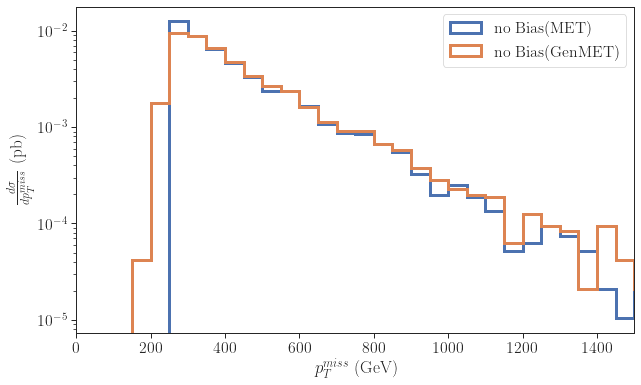

In [6]:
fig = plt.figure(figsize=(10,6))
for label,metPts in met.items():
    binc,binEdges,patches = plt.hist(metPts,bins=np.linspace(0,5000,101),
                               label=label+'(MET)',histtype='step',
                               weights=weights[label],linewidth=3)
#     errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
#     errorc = np.sqrt(errorc2)
#     binCenter = (binEdges[0:-1]+binEdges[1:])/2.
#     plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
#                  drawstyle = 'steps-mid',color=colors[label])

for label,metPts in genMet.items():
    binc,binEdges,patches = plt.hist(metPts,bins=np.linspace(0,5000,101),
                               label=label+'(GenMET)',histtype='step',
                               weights=weights[label],linewidth=3)
#     errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
#     errorc = np.sqrt(errorc2)
#     binCenter = (binEdges[0:-1]+binEdges[1:])/2.
#     plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
#                  drawstyle = 'steps-mid',color=colors[label])

# for label,metPts in dmPT.items():
#     binc,binEdges,patches = plt.hist(metPts,bins=np.linspace(0,5000,101),
#                                label=label+'(parton MET)',histtype='step',
#                                weights=weights[label],linewidth=3,linestyle='--')
#     errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
#     errorc = np.sqrt(errorc2)
#     binCenter = (binEdges[0:-1]+binEdges[1:])/2.
#     plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
#                  drawstyle = 'steps-mid',color=plt.gca().color())
    
        
    
plt.yscale('log')
# plt.ylim(1e-3,1)
plt.xlabel(r'$p_T^{miss}$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb)')
plt.xlim(0,1500)
plt.legend()
plt.show()

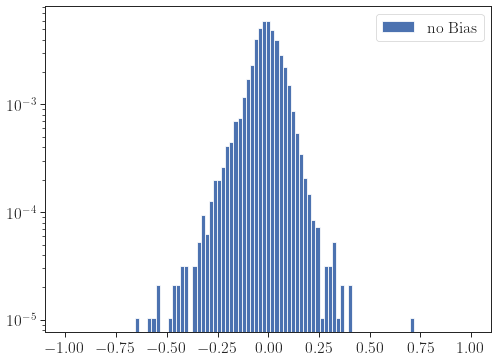

In [7]:
fig = plt.figure(figsize=(8,6))
for label,genmetPts in genMet.items():
    metPts = met[label]
    diffRatio = (metPts-genmetPts)/genmetPts
    plt.hist(diffRatio,bins=np.linspace(-1,1,100),weights=weights[label],label=label)
# plt.xlim(-100,100)
plt.yscale('log')
plt.legend()
plt.show()

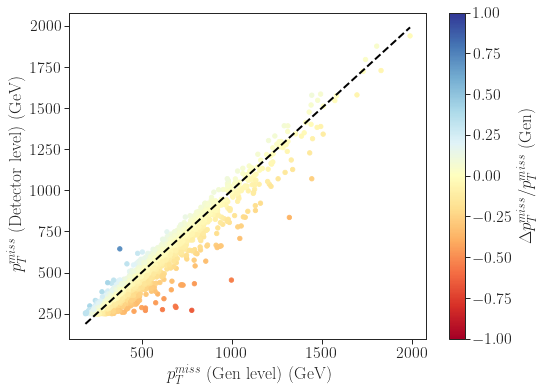

In [8]:
fig = plt.figure(figsize=(8,6))
for label,genmetPts in genMet.items():
    metPts = met[label]
    diffRatio = (metPts-genmetPts)/genmetPts
    plt.scatter(genmetPts,metPts,s=20,cmap=cm,c=diffRatio,vmin=-1,vmax=1)
plt.plot([genmetPts.min(),genmetPts.max()],[genmetPts.min(),genmetPts.max()],
         linestyle='--',linewidth=2,c='black')
plt.colorbar(label=r'$\Delta p_T^{miss}/p_T^{miss}$ (Gen)')
plt.xlabel(r'$p_T^{miss}$ (Gen level) (GeV)')
plt.ylabel(r'$p_T^{miss}$ (Detector level) (GeV)')
plt.show()